In [1]:
from Utils import true, false, evaluate_model, impute_data, resample_data, load_data
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

# Model Training using KNN Imputation
---
In this file, I will train the model using KNN imputation to handle missing values

# Attempt 1
---

Loading data from data.csv...
Loaded 308148 players from CSV
Resampling data...

Original distribution:
  Banned: 35,411 (14.36%)
  Non-banned: 211,107 (85.64%)

Resampled distribution:
  Banned: 208,623 (53.62%)
  Non-banned: 180,443 (46.38%)
Data resampling completed in 93.17852926254272 seconds



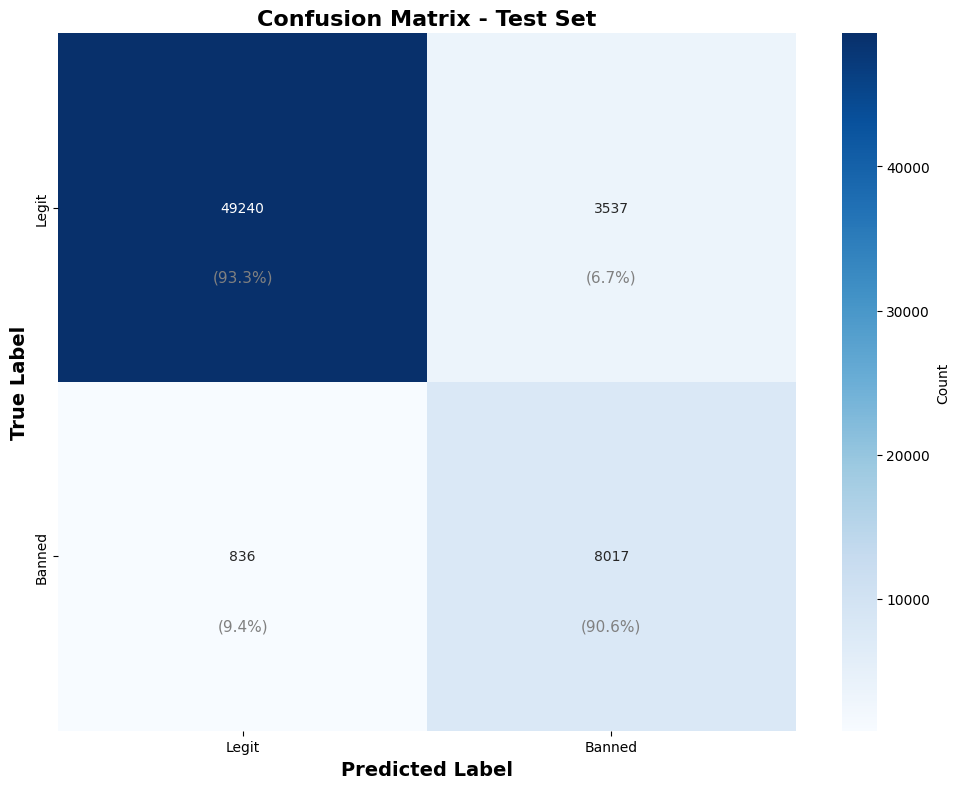

Metrics:
  ROC-AUC Score:           0.9712
  Precision (Banned):      0.6939
  Recall (Banned):         0.9056
  F1-Score (Banned):       0.7857
  False Positive Rate:     0.0670 (3,537 legit players incorrectly flagged)
  False Negative Rate:     0.0944 (836 cheaters missed)
  True Positives:          8,017 cheaters correctly identified
  True Negatives:          49,240 legit players correctly identified


In [2]:
player_data = load_data('data.csv')
banned_player_data = player_data[player_data['has_ban'] == true]
non_banned_player_data = player_data[player_data['has_ban'] == false]

high_missingness_features = [
    'he_friends_damage_avg',
    'rating_opening',
    'rating_ct_leetify',
    'rating_t_leetify',
    't_opening_aggression_success_rate',
    'rating_clutch',
    'rank_premier',
    'rank_faceit_elo'
]

features_to_exclude = high_missingness_features + ['steam_id', 'created_at', 'updated_at', 'total_matches']

numeric_cols = player_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in features_to_exclude]

banned_data = banned_player_data.copy()
non_banned_data = non_banned_player_data.copy()

for col in numeric_cols:
    banned_data.loc[banned_data[col] == 0, col] = np.nan
    non_banned_data.loc[non_banned_data[col] == 0, col] = np.nan

knn_imputer = KNNImputer(n_neighbors=5, weights='distance')

banned_imputed_values = knn_imputer.fit_transform(banned_data[numeric_cols])
banned_imputed = banned_data.copy()
banned_imputed[numeric_cols] = banned_imputed_values

non_banned_imputed_values = knn_imputer.fit_transform(non_banned_data[numeric_cols])
non_banned_imputed = non_banned_data.copy()
non_banned_imputed[numeric_cols] = non_banned_imputed_values

imputed_player_data = pd.concat([banned_imputed, non_banned_imputed], ignore_index=True)

columns_to_exclude = ['steam_id', 'created_at', 'name', 'total_matches', 'updated_at', 'has_ban'] + high_missingness_features
X = imputed_player_data.drop(columns=columns_to_exclude)
y = imputed_player_data['has_ban'].map({true: 1, false: 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 80% train, 20% test
    random_state=42,
    stratify=y
)
X_train_resampled, y_train_resampled = resample_data(X_train, y_train)

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=100,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train_resampled, y_train_resampled)
evaluate_model(clf, X_test, y_test, show_plot=True)

# Results
---
In the above cell, I dropped features which were missing an extreme amount of values and imputed the rest. The results were impressive but need to be a lot better. We are flagging to many legit players. Im happy with the amount of cheaters we are missing but still better would be nice.

# Attempt 2
---
This time im not going to drop the features with the highest amount of missing values and instead see what happens if I try impute them as well

In [ ]:
player_data = load_data('data.csv')
imputed_player_data = impute_data(player_data)

columns_to_exclude = ['steam_id', 'created_at', 'name', 'total_matches', 'updated_at', 'has_ban', 'rank_premier', 'rank_faceit_elo']
X = imputed_player_data.drop(columns=columns_to_exclude)
y = imputed_player_data['has_ban'].map({true: 1, false: 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train_resampled, y_train_resampled = resample_data(X_train, y_train)

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=100,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train_resampled, y_train_resampled)
evaluate_model(clf, X_test, y_test, show_plot=True)

Loading data from data.csv...
Loaded 308148 players from CSV
Imputing data...


# Results
---
Imputing all the features seems to work ever so slightly better, slightly less legits incorrectly flagged and less cheaters missed